# Death Comparison

This script was written to provide easy interpretation of death statistics for four locations. It has been initialised to load the data available [here](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard) The link allows an excel file to be downloaded. This script requires the 'Occurrences - All data' to be exported into a single CSV file.

I make no claim that this script is overly efficient, it was made for personal interest.

Any questions please contact:
> Andrew Paul Barnes<br>
> Doctoral Student & Teaching Assistant<br>
> Department of Architecture and Civil Engineering<br>
> University of Bath<br>
> a.p.barnes@bath.ac.uk

## Libraries

To begin several libraries are imported to allow easy manipulation of the data.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.lines import Line2D

## Loading Data Required

First the areas of interest are defined in the variable *AREAS* and the file name/location are given in *MASTER_FILE*.

In [2]:
AREAS = ["Swindon", "Northampton", "Wiltshire", "Cheltenham"]
MASTER_FILE = "occurrences-alldata.csv"

Next, the CSV file is loaded and mined to retrieve only the areas indicated above and only covid-19 related deaths.

In [3]:
# Load data
weekly_deaths = pd.read_csv(MASTER_FILE, delimiter=',', skiprows=3)

# Filter to only contain the areas of interest
weekly_deaths = weekly_deaths.loc[weekly_deaths['Area name'].isin(AREAS)]
weekly_deaths = weekly_deaths.loc[weekly_deaths['Cause of death'] == "COVID 19"]

# Select the columns required
weekly_deaths = weekly_deaths[["Area name", "Week number", "Place of death", "Number of deaths"]]

# Extract the range of death locations and enumerate them.
death_locations = weekly_deaths["Place of death"].unique().tolist()
for locidx, dloc in enumerate(death_locations):
    weekly_deaths = weekly_deaths.replace(to_replace=dloc, value=locidx)

Finally, split the data into areas. This step is to simplify the process of plotting and aggregating of weekly data.

In [4]:
def split_data(deaths, areas):
    """ Splits the data from a master pandas sheet into area matrices. """
    area_matrices = {}
    for area in areas:
        area_matrices[area] = deaths.loc[deaths['Area name'] == area].iloc[:, 1:].to_numpy()
    return area_matrices
area_data = split_data(weekly_deaths, AREAS)

## Weekly Deaths Comparison

This first analysis section will take the weekly total deaths of each area and generate a graph showing how these vary in each chosen area.

In [5]:
def generate_weekly_totals(data):
    """ Combines the data into weekly death totals per area. """
    weekly_data = {}
    for area in data:
        weekly_data[area] = np.zeros((2, np.max(data[area][:, 0])))
        for week in range(1, np.max(data[area][:, 0])+1):
            weekly_data[area][0, week-1] = week
            weekly_data[area][1, week-1] = np.sum(data[area][data[area][:, 0] == week, -1])
    return weekly_data
weekly_data = generate_weekly_totals(area_data)

Next, we plot the weekly deaths data for each area on the same graph.

**BEWARE** interpreting this data is not as easy as first though, different population sizes, densities and other factors all play a role.

Text(0.5, 1.0, 'Total COVID-19 Deaths')

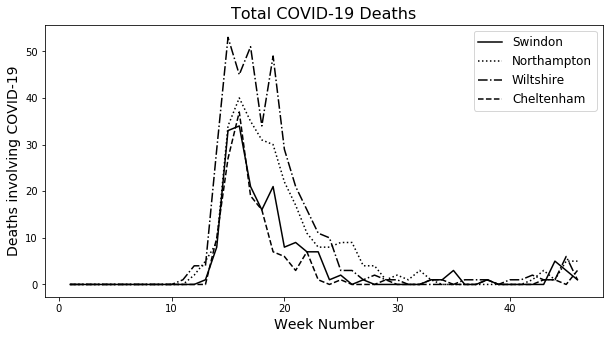

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

linetypes = ["-", ":", "-.", "--"]

for idx, area in enumerate(AREAS):
    axs.plot(weekly_data[area][0, :], weekly_data[area][1, :], ls=linetypes[idx], c='k', label=area)

axs.set_xlabel("Week Number", fontsize=14)
axs.set_ylabel("Deaths involving COVID-19", fontsize=14)
axs.legend(fontsize=12)
axs.set_title("Total COVID-19 Deaths", fontsize=16)

## Death Location Comparison

Next we show the proportion of deaths which occur in each location (Care homes, hospitals etc.) in each area chosen.

In [7]:
def generate_weekly_proportions(data, dlocs):
    """ Converts the area data into a time series for each unique death location.
        These are then converted into percentages of the week's deaths. """
    location_data = {}
    for area in data:
        location_data[area] = np.zeros((1+len(dlocs), np.max(data[area][:, 0])))
        for week in range(1, np.max(data[area][:, 0])+1):
            location_data[area][0, week-1] = week
            total_weekly = np.sum(data[area][data[area][:, 0] == week, -1]) # Stolen from previous part
            for idx in range(0, len(dlocs)):
                # Extract the number of deaths for this location
                location_data[area][1+idx, week-1] = data[area][(data[area][:, 0] == week) & (data[area][:, -2] == idx), -1]
                # Calculate percentage
                if total_weekly != 0 and location_data[area][1+idx, week-1] != 0:
                    location_data[area][1+idx, week-1] = location_data[area][1+idx, week-1] / total_weekly
    return location_data
location_data = generate_weekly_proportions(area_data, death_locations)

Plotting the data as separate stacked barcharts per area.

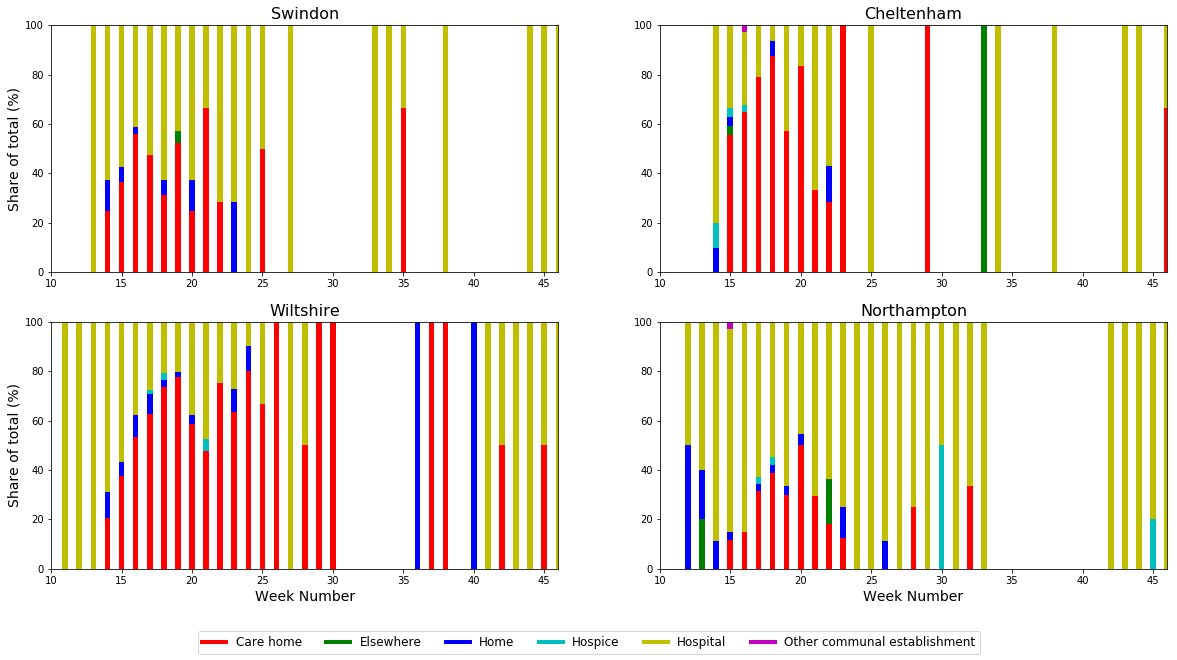

In [8]:
fig, all_axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

colours = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
bar_width = 0.4

axes=[[0,0], [1,1], [1,0], [0,1]]

for idx, area in enumerate(AREAS):
    axs = all_axs[axes[idx][0], axes[idx][1]]
    # For each week we create a separate set of bars
    for week in location_data[area][0, :].astype(int):
        previous_value = 0
        # Plot each location separately
        for dloc in range(0, len(death_locations)):
            axs.bar(week, location_data[area][1+dloc, week-1]*100,
                    bar_width, bottom=previous_value, color=colours[dloc])
            previous_value = previous_value + location_data[area][1+dloc, week-1]*100
    axs.set_xlim([10, 46])
    axs.set_title(area, fontsize=16)
all_axs[1, 0].set_xlabel("Week Number", fontsize=14)
all_axs[1, 1].set_xlabel("Week Number", fontsize=14)

all_axs[0, 0].set_ylabel("Share of total (%)", fontsize=14)
all_axs[1, 0].set_ylabel("Share of total (%)", fontsize=14)

# Overly complicated legend
bars = []
for idx, b in enumerate(death_locations):
    bars.append(Line2D([0], [0], color=colours[idx], lw=4))

fig.legend(bars, death_locations, loc="lower center", ncol=len(death_locations), fontsize=12)

## Correlation to Area 0

This next section of script first plots the number of deaths in area 0 against the number of deaths in the remaining areas.

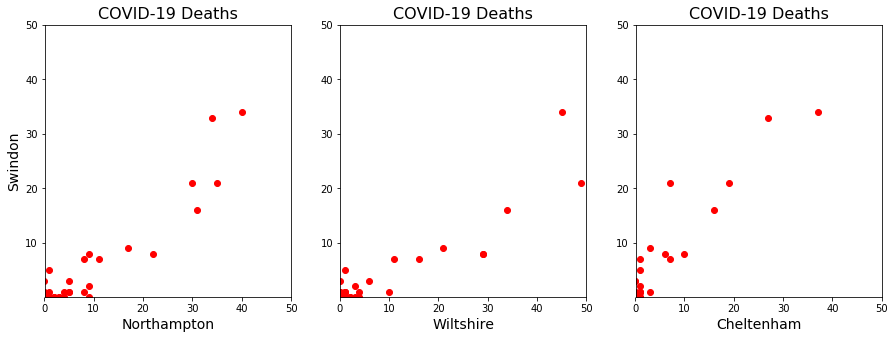

In [27]:
def plot_area_scatters(area_data):
    """ Plots a scatter graph of Area-0 deaths against all other areas. """
    area_keys = list(area_data.keys())
    # Extract area 0 deaths (for y-axis.)
    area_0 = area_data[area_keys[0]][1, :]
    # Create the plot
    fig, axs = plt.subplots(nrows=1, ncols=len(area_keys)-1, figsize=(15, 5))
    for idx, area in enumerate(area_keys[1:]):
        axs[idx].scatter(area_data[area][1, :], area_0, c='r')
        axs[idx].set_xlim([0.1, 50])
        axs[idx].set_ylim([0.1, 50])
        axs[idx].set_xlabel(area, fontsize=14)
        axs[idx].set_title("COVID-19 Deaths", fontsize=16)
    axs[0].set_ylabel(area_keys[0], fontsize=14)
plot_area_scatters(weekly_data)

Next, we do the same task, but this time a linear regression is performed to identify the strength of the correlation.

In [34]:
def get_estimations(m, c, xs=np.arange(0, 51)):
    """ Produces estimations for y given the xs, the slope (m) and intercept (c) using y = mx + c. """
    return (xs * m) + c

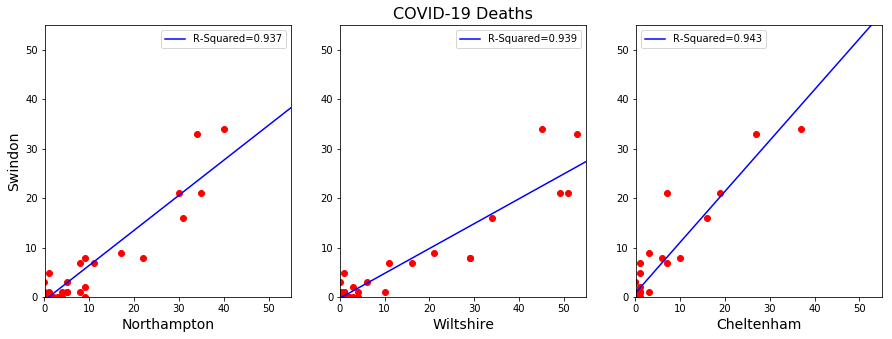

In [49]:
def plot_area_scatters(area_data):
    """ Plots a scatter graph of Area-0 deaths against all other areas. """
    area_keys = list(area_data.keys())
    # Extract area 0 deaths (for y-axis.)
    area_0 = area_data[area_keys[0]][1, :]
    # Create the plot
    fig, axs = plt.subplots(nrows=1, ncols=len(area_keys)-1, figsize=(15, 5))
    for idx, area in enumerate(area_keys[1:]):
        axs[idx].scatter(area_data[area][1, :], area_0, c='r')
        slope, intercept, r_value, p_value, std_err = linregress(area_data[area][1, :], area_0)
        axs[idx].plot(np.arange(0, 56), get_estimations(slope, intercept, np.arange(0, 56)), c='b', label="R-Squared={:.3f}".format(r_value))
        axs[idx].set_xlim([0.1, 55])
        axs[idx].set_ylim([0.1, 55])
        axs[idx].set_xlabel(area, fontsize=14)
        axs[idx].legend()
    axs[1].set_title("COVID-19 Deaths", fontsize=16)
    axs[0].set_ylabel(area_keys[0], fontsize=14)
plot_area_scatters(weekly_data)